# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
# checking python version
import sys
print(f"Python version : {sys.version}")

Python version : 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]


### 1) Importer le tableau de données dans un dataframe 

In [3]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv")

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

**Réponse :**

Le dataset est constitué de **6 colonnes différentes**, nous récupérons le nom de ces différentes colonnes puis les ajoutons dans une liste appelée `categories`. Ensuite nous allons pouvoir étudier chaque valeur manquante de ce dataset en utilisant des méthodes implémentées directement dans la librairie `pandas`.

In [4]:
# get the label names
categories = [categories for categories in df.columns]
print(categories)

['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience', 'Ville']


Par habitude, nous allons utiliser `X_data` pour nommer les listes de données.

In [5]:
# get the data values using the features we defined before
X_data = df[categories]

# visualize the shape of the data we've collected
print(f"Data shape : {X_data.shape} \nNumber of rows : {X_data.shape[0]} \nNumber of columns : {X_data.shape[1]}")

Data shape : (9582, 6) 
Number of rows : 9582 
Number of columns : 6


Le dataset est constitué de **9582 lignes** (instances/observations) et de **6 colonnes** en référence aux catégories que nous avions extraites au préalable.
Désormais, sachant que nous connaissons les différentes catégories et le nombre de données disponibles, nous allons pouvoir creuser un peu plus en détails, en commençant par passer en revue **les premières données du dataset**. Pour ce faire, nous allons utiliser la méthode **head()**.

In [6]:
# quick review of the data
X_data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


Nous regardons ensuite le nombre de valeurs manquantes dans notre dataset en utilisant les méthodes **isna()** ou **isnull()** directement disponibles à travers `pandas`.

In [7]:
# checking the na values in our dataset and summing them 
na_values = X_data.isna()
number_na = na_values.sum()
total_number_na = number_na.sum()

print(f"Number of missing values per categories :\n")
print(f"{number_na} \n\nTotal of missing values in all categories : {total_number_na}")

Number of missing values per categories :

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64 

Total of missing values in all categories : 130


Nous pouvons observer qu'il y a des valeurs manquantes (`NaN`) dans les catégories **`Experience`**, **`Metier`** et **`Entreprise`**.

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

**Réponse :**

Il y a plusieurs façons de remédier aux problèmes des valeurs manquantes, dans cet exercice nous allons utiliser les méthodes fournies directement dans `pandas`, mais nous pouvons aussi utiliser celle de `scikit-learn` avec le module `SimpleImputer`.  

La méthode **fillna()** de `pandas` nous permet de "impute" de nouvelles valeurs sur les valeurs manquantes, tout en choisissant la manière que l'on veut **i.e.** en remplaçant par la médiane des valeurs ou la moyenne (au choix). D'après nos observations, seules les colonnes **`Experience`**, **`Metier`** et **`Entreprise`** possèdent des valeurs manquantes. Sachant que la colonne **`Experience`** est la seule contenant des *valeurs numériques* nous pouvons donc "imputer" les valeurs médianes et moyennes seulement dans cette colonne.

In [8]:
# make copy to avoid changing original data 
X_data_copy = X_data.copy()

In [9]:
# we get the data type of the values in the category 'Experience'
X_data_copy['Experience'].dtypes
# output dtype = object

dtype('O')

En regardant attentivement les données dans la catégorie **`Experience`**, nous avons remarqué que les valeurs décimales sont sous un format à virgule et que le type de données de la colonne est `object`.  
Il est donc nécessaire de transformer le type de données de la colonne **`Experience`** en `float` pour pouvoir calculer la valeur moyenne et la valeur médiane, mais aussi de remplacer **TOUTES** les virgules par des points.

In [10]:
# convert the object types to float type
X_data_copy['Experience'] = X_data_copy['Experience'].str.replace(',', '.').astype(float)
X_data_copy['Experience'].dtypes

dtype('float64')

Nous utilisons ensuite la méthode **loc()** pour imposer nos conditions et localiser les différents métiers correspondant à la colonne **`Experience`** qui nous intéresse. Finalement, nous allons imputer les valeurs moyennes et médianes correspondantes à ces métiers dans la colonne **`Experience`**. 

**A noter que** : si nous nous trompons dans l'orthographe du métier dans la condition (cf. mask), `pandas` ne prendra pas en compte les instructions que l'on confie ensuite **i.e** : les lignes contenant des valeurs manquantes ne seront pas remplies.

In [11]:
# we'll use masks to respect the conditions, here we want to put median value experience for data scientist
mask1 = (X_data_copy['Metier'] == 'Data scientist')
X_data_copy.loc[mask1, 'Experience'] = X_data_copy.loc[mask1, 'Experience'].fillna(X_data_copy.loc[mask1, 'Experience'].median())

# we'll use masks to respect the conditions, here we want to put median value experience for lead data scientist
mask2 = (X_data_copy['Metier'] == 'Lead data scientist')
X_data_copy.loc[mask2, 'Experience'] = X_data_copy.loc[mask2, 'Experience'].fillna(X_data_copy.loc[mask2, 'Experience'].median())

# we'll use masks to respect the conditions, here we want to put mean value experience for data engineer
mask3 = (X_data_copy['Metier'] == 'Data engineer')
X_data_copy.loc[mask3, 'Experience'] = X_data_copy.loc[mask3, 'Experience'].fillna(X_data_copy.loc[mask3, 'Experience'].mean())

In [54]:
# checking the results by verifying is there are still any missing values
print(f"Are there any missing values for data scientist? : {X_data_copy.loc[mask1, 'Experience'].isna().any()}")
print(f"Are there any missing values for lead data scientist? : {X_data_copy.loc[mask2, 'Experience'].isna().any()}")
print(f"Are there any missing values for data engineer? : {X_data_copy.loc[mask3, 'Experience'].isna().any()}")

# we can check the X_data values to be sure
X_data_copy.head()

Are there any missing values for data scientist? : False
Are there any missing values for lead data scientist? : False
Are there any missing values for data engineer? : False


,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux


Nous pouvons observer les statistiques de la colonne `Experience` en utilisant la méthode **describe()**.

In [15]:
# we get the values back in X_data
X_data = X_data_copy
# generate descriptive statistics of the 'Experience' column which is the only column with float values
X_data.describe()

,Experience
count,9559.000000
mean,2.813181
std,2.706779
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


A partir des données statistisques que nous avons récupéré et les codes écrits précédents, nous pouvons répondre à la question suivante.

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

**Réponse :**

In [16]:
# mask for data architecte 
mask4 = (X_data['Metier'] == 'Data architecte')

# mean values calculations
mean_values_data_scientist = X_data.loc[mask1, 'Experience'].mean()
mean_values_lead_data_scientist = X_data.loc[mask2, 'Experience'].mean()
mean_values_data_engineer = X_data.loc[mask3, 'Experience'].mean()
mean_values_data_architecte = X_data.loc[mask4, 'Experience'].mean()

print(f'Mean value for years of experience working (data scientist) : {mean_values_data_scientist:.2f} years') 
print(f'Mean value for years of experience working (Lead data scientist) : {mean_values_lead_data_scientist:.2f} years') 
print(f'Mean value for years of experience working (data engineer) : {mean_values_data_engineer:.2f} years') 
print(f'Mean value for years of experience working (data architecte) : {mean_values_data_architecte:.2f} years') 

Mean value for years of experience working (data scientist) : 2.24 years
Mean value for years of experience working (Lead data scientist) : 3.96 years
Mean value for years of experience working (data engineer) : 2.98 years
Mean value for years of experience working (data architecte) : 3.00 years


In [17]:
# mean value for all :
mean_value = 1/4*(mean_values_data_scientist + mean_values_lead_data_scientist 
                                             + mean_values_data_engineer 
                                             + mean_values_data_architecte)

print(f'Mean value for years of experience working for all types of jobs : {mean_value:.2f} years') 

Mean value for years of experience working for all types of jobs : 3.05 years


La valeur moyenne d'expérience au travail d'un data architecte **est très suspecte**, nous vérifions donc s'il manque des valeurs dans le dataset de cette catégorie de travail.

In [18]:
print(f"Are there any missing values for data architecte? : {X_data.loc[mask4, 'Experience'].isna().any()}")
print(f"There are {X_data.loc[mask4, 'Experience'].isna().sum()} missing year of working experience values for the data architecte job.")

Are there any missing values for data architecte? : True
There are 23 missing year of working experience values for the data architecte job.


Nous observons qu'il y a 23 valeurs manquantes (missing values) pour le métier de **data architecte**, néanmoins il n'y a aucune consigne indiquée pour imputer ces valeurs manquantes. Nous pouvons donc décider oui ou non d'imputer une moyenne des valeurs pour ces valeurs manquantes.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

**Réponse :**

<AxesSubplot:xlabel='Metier', ylabel='Experience'>

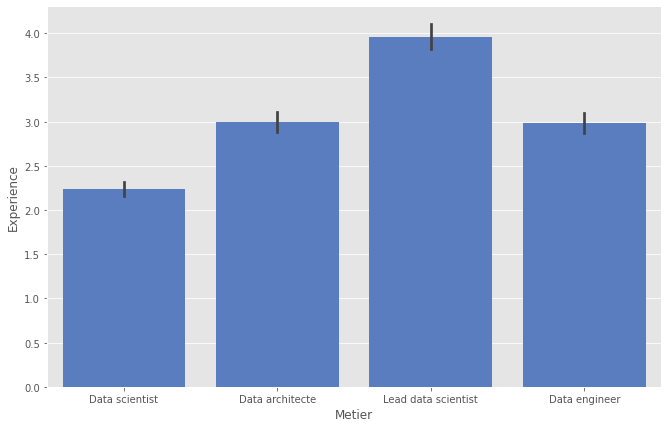

In [19]:
# plot the mean value of year experience for each jobs
f, ax = plt.subplots(figsize=(11, 7))
sb.set_color_codes("muted")
sb.barplot(x='Metier', y='Experience', data=X_data, color='b')

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

**Réponse :** 

Il y a différentes façons de transformer des variables **continues** en **catégorielles**, parmi elles, il y a les techniques classiques dites de **"label encoding"** ou de **"one-hot encoding"**. Pour la méthode de **"label encoding"** les variables continues doivent être *ordonnées* c'est à dire qu'elles doivent respecter un ordre ou une hiérarchie entre elles. 

Prenons l'exemple d'une variable **`Brossage de dents après le petit-déj`** contenant des valeurs ordonnées : `Tous les jours` ,`Jamais` ,`Rarement`, `Parfois`; nous observons donc bien une hiérarchie entre les valeurs possibles de cette variable. Nous pouvons, dès lors, appliquer la méthode de **"label encoding"** pour transformer la variable continue en variable catégorielle à 4 modalités (classées par ordre hiérarchique): 

* `Jamais` (0) <  `Rarement` (1) < `Parfois` (2) < `Tous les jours` (3).

Dans notre cas d'étude, nous allons transformer notre variable continue **`Experience`** en variable catégorielle **`Exp_label`** à 4 modalités en utilisant une méthode implémentée dans `pandas` directement.  
Nous allons encoder la nouvelle variable catégorielle comme suit (classées par ordre hiérarchique) : 

* `Débutant` (0) <  `Confirmé` (1) < `Avancé` (2) < `Expert` (3).

Il existe plusieurs façons de faire du **"label encoding"**, en utilisant le module `LabelEncoder` dans `scikit-learn`  ou bien les méthodes de catégorisation de `pandas`. Dans ce cas de figure, nous allons utiliser les méthodes de `pandas`.

In [20]:
# make copy to avoid changing original data 
label_X_data = X_data.copy()

In [21]:
# encode the new column using cut() method from pandas
label_X_data['Exp_label'] = pd.cut(label_X_data['Experience'], 4, labels=['Débutant', 'Confirmé', 'Avancé', 'Expert'])
# check the result
label_X_data['Exp_label']

0       Débutant
1       Débutant
2       Débutant
3       Débutant
4       Débutant
          ...   
9577    Débutant
9578      Avancé
9579    Débutant
9580      Expert
9581    Débutant
Name: Exp_label, Length: 9582, dtype: category
Categories (4, object): ['Débutant' < 'Confirmé' < 'Avancé' < 'Expert']

In [22]:
# get an overall view of the new transformed dataset 
label_X_data.head(7)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,Débutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,Débutant
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,Débutant
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,Débutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,Débutant
5,S&P Global Ratings,Lead data scientist,VBA/Python/Excel/R,Master,6.0,Lille,Confirmé
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0.0,Lille,Débutant


Nous avons donc bien réussi à créer une colonne **`Exp_label`** avec des valeurs de variables catégorielles respectant la hiérarchie suivante : 
* `Débutant` (0) <  `Confirmé` (1) < `Avancé` (2) < `Expert` (3).

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique


**Réponse :**

Nous allons d'abord prétaiter les données contenues dans la colonne **`Technologies`**, nous transformons la colonne en `list` puis faisons en sorte de rassembler tous les éléments de cette liste ensemble dans un **dictionnaire**. A partir de ce **dictionnaire**, nous allons compter le nombre de répétitions des différentes technologies, et ainsi pouvoir déterminer lesquelles sont les plus utilisées. Pour ce faire, nous allons utiliser la méthode **count()**. 

In [23]:
# make copy to avoid changing original data 
lst_X_data = label_X_data.copy()
# for checking
#print(lst_X_data['Technologies'])

In [24]:
# function to extract
def extract_slash(lst): 
    """ This function split the elements with a slash suffix"""
    res = [] 
    for element in lst: 
        sub_list = element.split('/')         
        res.append(sub_list)       
    return(res) 

Nous choisissons d'utiliser une méthode de comptage à l'aide d'un **dictionnaire Python**, ce n'est pas la meilleure méthode car elle est assez lente (quelques secondes d'attente lors d'un run). Néanmoins, elle reste très efficace et permet de classer **par ordre décroissant** le nombre d'apparitions des technologies à travers le dataset.

In [25]:
# transform into a list
raw_tech_list = lst_X_data['Technologies'].tolist()

# extract elements with a slash suffix and stored them in sublists
raw_tech_list = extract_slash(raw_tech_list)
tech_list = []
for elem in raw_tech_list:
    tech_list.extend(elem)

# check our dict before processing
tech_dict_no_processed = {i:tech_list.count(i) for i in tech_list}
print(tech_dict_no_processed)

{'Matlab': 871, 'Python': 6627, 'Pyspark': 448, 'Scikit-learn': 313, 'Tensorflow': 848, 'Java': 1719, 'Scala': 310, 'MongoDB': 1166, 'SPSS': 359, 'SQL': 2581, 'Teradata': 610, 'R': 4374, 'scikit-learn': 476, 'C': 739, 'C++': 1381, 'numpy': 140, 'VBA': 1003, 'Excel': 1398, 'PySpark': 145, 'Linux': 1183, 'Docker': 927, 'GNU': 677, 'Hadoop': 1589, 'Hive': 864, 'MariaDB': 335, 'machine learning': 996, 'Spark': 1240, 'AWS': 691, 'Deep learning': 227, 'PostgreSQL': 208, 'Elasticsearch': 826, 'Kibana': 728, 'HDFS': 361, 'Yarn': 206, 'Microsoft Azure': 338, 'Redshift': 124, 'SAS': 943, 'Machine learning': 458, 'Anglais': 458, 'anglais': 145, 'AI': 250, 'Scoring': 250, 'Perl': 74, 'Ruby': 35, 'Pycharm': 235, 'Vertica': 250, 'Tableau': 250, '': 539, 'Big data': 824, 'Kafka': 235, 'ORACLE': 94, 'MySQL': 94, 'Cassandra': 284, 'NoSQL': 232, 'Matplotlib': 273, 'Map-Reduce': 155, 'PIG': 155, 'HBASE': 155, 'Windows': 75, 'NoSQ': 123, 'Hadoop(HDFS)': 98}


Nous remarquons qu'il y a des soucis dans les noms de certaines technologies. En effet par exemple pour `scikit-learn` : il y a deux écritures différentes dans notre colonne **`Technologies`**, avec le **s** majuscule ou mininuscule; nous devons donc uniformiser et corriger toutes les erreurs dans tous les mots-clés nommant les technologies, avant de pouvoir faire notre compte.

In [26]:
# replace all the redundants words with only 1 version
def get_processed(tech_list):
    """ Processing error names """
    tech_list_processed = []
    for tech in tech_list:
        word1 = tech.replace("Pyspark", "PySpark"
                             ).replace("scikit-learn", "Scikit-learn"
                             ).replace("anglais", "Anglais"
                             ).replace("machine learning", "Machine Learning"
                             ).replace("Machine learning", "Machine Learning"
                             ).replace("Hadoop(HDFS)", "HDFS"
                             ).replace("NoSQ", "NoSQL"
                             ).replace("NoSQLL", "NoSQL")
        tech_list_processed.append(word1)
    
    return tech_list_processed

In [27]:
tech_list_processed = get_processed(tech_list)

# processed dict
tech_dict = {i:tech_list_processed.count(i) for i in tech_list_processed}
# getting rid of phantom technologies names
tech_dict.pop('', None)
# sorted technologies dict in descending order
sorted_dict = dict(sorted(tech_dict.items(), key=lambda item:item[1], reverse=True))
print(sorted_dict)

{'Python': 6627, 'R': 4374, 'SQL': 2581, 'Java': 1719, 'Hadoop': 1589, 'Machine Learning': 1454, 'Excel': 1398, 'C++': 1381, 'Spark': 1240, 'Linux': 1183, 'MongoDB': 1166, 'VBA': 1003, 'SAS': 943, 'Docker': 927, 'Matlab': 871, 'Hive': 864, 'Tensorflow': 848, 'Elasticsearch': 826, 'Big data': 824, 'Scikit-learn': 789, 'C': 739, 'Kibana': 728, 'AWS': 691, 'GNU': 677, 'Teradata': 610, 'Anglais': 603, 'PySpark': 593, 'HDFS': 459, 'SPSS': 359, 'NoSQL': 355, 'Microsoft Azure': 338, 'MariaDB': 335, 'Scala': 310, 'Cassandra': 284, 'Matplotlib': 273, 'AI': 250, 'Scoring': 250, 'Vertica': 250, 'Tableau': 250, 'Pycharm': 235, 'Kafka': 235, 'Deep learning': 227, 'PostgreSQL': 208, 'Yarn': 206, 'Map-Reduce': 155, 'PIG': 155, 'HBASE': 155, 'numpy': 140, 'Redshift': 124, 'ORACLE': 94, 'MySQL': 94, 'Windows': 75, 'Perl': 74, 'Ruby': 35}


In [28]:
# get the first 5 most used technologies
max_5_values_tech_dict = sorted(tech_dict, key=tech_dict.get, reverse=True)[:5]
max_5_values_tech_dict

['Python', 'R', 'SQL', 'Java', 'Hadoop']

**Résultats :** 

Les 5 technologies les plus utilisées sont : 
- Python (6627 apparitions)
- R      (4374 apparitions)
- SQL    (2581 apparitions)
- Java   (1719 apparitions)
- Hadoop (1589 apparitions)

Vu que l'on a traité au préalable les éléments de la liste `Technologies`, et qu'on les a stockés dans un **dictionnaire**, nous pouvons désormais tracer un histogramme des **5 technologies les plus utilisées**.

<BarContainer object of 5 artists>

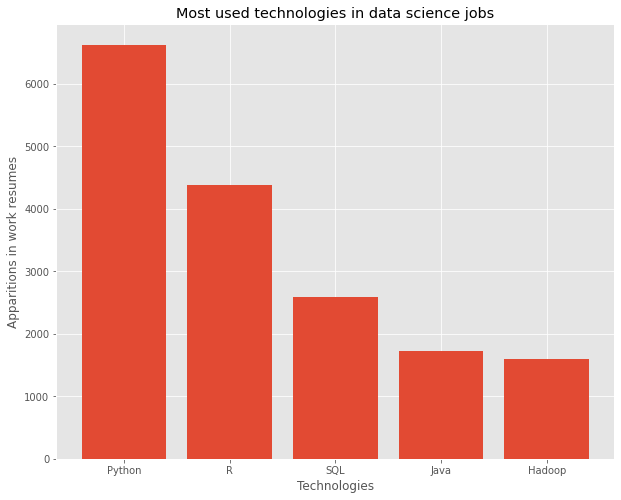

In [29]:
# plot histogram
f, ax = plt.subplots(figsize=(10, 8))

ax.set_ylabel('Apparitions in work resumes')
ax.set_xlabel('Technologies')
ax.set_title('Most used technologies in data science jobs')

# limit our dictionnary to the first max used technologies
max_value = 5
keys = dict(list(sorted_dict.items())[0:max_value]).keys()
values = dict(list(sorted_dict.items())[0:max_value]).values()

plt.bar(keys,values)

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

**Message** : (*Malheureusement je n'ai fait majoritairement que de l'algorithme supervisé et surtout qu'en Deep Learning, donc mes connaissances en ML et surtout dans le non supervisé sont très limitées voir quasi inexistantes... mais je vais quand même essayer de répondre à cette question.*)


**Réponse :**  
Pour cette question, nous allons utiliser les algorithmes de clustering présent dans `scikit-learn`. Nous jugeons pertinent qu'il y ait un rapport entre les colonnes `Metier` et `Experience`, nous allons donc faire apparaître deux clusters regroupant d'un côté les **ingénieurs débutants** et leurs métiers respectifs et de l'autre les **plus expérimentés** et leurs métiers respectifs.

### Prétraitement :

Comme nous l'avons dit précédemment, il y a des valeurs d'expérience manquantes pour le travail de Data Engineer. Nous décidons alors de **reconstituer un nouveau dataset** (à partir du dataset *d'avant imputation* de la question 3) en remplissant les profils d'expérience du Data Engineer par une **valeur d'expérience médiane** (dans la colonne `Experience`) qui est arbitraire. 

Nous avons donc ainsi créé la nouvelle catégorie `Exp_label` mise à jour par rapport à celle que l'on avait auparavant (dans les précédentes questions).

In [30]:
# copy the dataset before applying categorical encoding (in the question 3)
X_cluster_data = X_data.copy()
#X_cluster_data
# we're checking if there are any missing values 
print(X_cluster_data.isna().any())

Entreprise       True
Metier           True
Technologies    False
Diplome         False
Experience       True
Ville           False
dtype: bool


Il y a des valeurs manquantes dans la colonne `Experience`, nous allons y remédier dans les blocs suivants.

In [31]:
# convert the column type to float type
X_cluster_data['Experience'] = X_cluster_data['Experience'].astype(float)
# mask for data architecte (cf question 4)
mask4 = (X_data['Metier'] == 'Data architecte')

print(f"Are there any missing values for data architecte? : {X_cluster_data.loc[mask4, 'Experience'].isna().any()}")
print(f"There are {X_cluster_data.loc[mask4, 'Experience'].isna().sum()} missing year of working experience values for the data architecte job.")

Are there any missing values for data architecte? : True
There are 23 missing year of working experience values for the data architecte job.


Nous effectuons le remplissage des valeurs manquantes à travers le bloc suivant.

In [33]:
# fill na values for data architecte experience in 'Experience' column 
X_cluster_data.loc[mask4, 'Experience'] = X_cluster_data.loc[mask4, 'Experience'].fillna(X_cluster_data['Experience'].median())

# test if there are still na values 
print(f"Are there any missing values for data architecte? : {X_cluster_data.loc[mask4, 'Experience'].isna().any()}")
print(f"There are {X_cluster_data.loc[mask4, 'Experience'].isna().sum()} missing year of working experience values for the data architecte job.")

Are there any missing values for data architecte? : False
There are 0 missing year of working experience values for the data architecte job.


Il n'y a désormais plus aucune valeurs manquantes dans nos données essentielles (`Experience` et `Exp_label`).

In [37]:
# encode the new column using cut() method from pandas
X_cluster_data['Exp_label'] = pd.cut(X_cluster_data['Experience'], 4, labels=['Débutant', 'Confirmé', 'Avancé', 'Expert'])
X_cluster_data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,Débutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,Débutant
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,Débutant
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,Débutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,Débutant


In [35]:
# check if there are still missing values
print(f"Are there any missing values for the 'Experience' column ? {X_cluster_data['Experience'].isna().any()}")
print(f"Are there any missing values for the 'Exp_label' column ? {X_cluster_data['Exp_label'].isna().any()}")
# generate descriptive statistics of the 'Experience' column which is the only column with float values
print(f"\nStatistical data of the 'Experience' column after filling missing values from data architecte jobs:")
X_cluster_data.describe()

Are there any missing values for the 'Experience' column ? False
Are there any missing values for the 'Exp_label' column ? False

Statistical data of the 'Experience' column after filling missing values from data architecte jobs:


,Experience
count,9582.000000
mean,2.811229
std,2.703821
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


### Récupération des colonnes 

Nous récupérons donc les colonnes qui nous intéressent pour ce problème.

In [38]:
# we define the clusters category columns
clusters_category = pd.DataFrame(X_cluster_data, columns=['Experience', 'Metier'])
# checking missing values
print(clusters_category.isna().any())
#clusters_category

Experience    False
Metier         True
dtype: bool


Pour pouvoir appliquer l'algorithme non supervisé `KMeans`, il faut que les données de la colonne **`Metier`** soit au format labellisé (`float` ou `int`) pour permettre leur exploitation. Sachant que nous savons déjà que les valeurs dans cette colonne sont hiérarchisées (**cf. q6**), nous pouvons effectuer une méthode d'encodage directement sur la colonne **`Metier`** pour convertir les valeurs `str` en labels exploitables de type `int` prenant la valeur 0 ou 1.

In [39]:
# convert the 'Metier' column type to categorical
clusters_category['Metier'] = clusters_category['Metier'].astype('category')
# Get list of categorical variables
data_type_object = (clusters_category.dtypes == 'category')
categorical_cols = list(data_type_object[data_type_object].index)

# check the dataset
print(f"Categorical variables:")
print(categorical_cols)

Categorical variables:
['Metier']


Nous allons donc appliquer une méthode d'encodage appelée (**one-hot encoding**) sur la variable continue **`Metier`** pour pouvoir exploiter les valeurs de celle-ci dans le cadre de notre algorithme non supervisé.

In [40]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
clusters_category = pd.DataFrame(OH_encoder.fit_transform(clusters_category[categorical_cols]))

# get back the name of the columns
clusters_category.columns = OH_encoder.get_feature_names()
# One-hot encoding removed index; put it back
clusters_category.index = X_cluster_data.index
# Remove categorical columns (will replace with one-hot encoding)
num_clusters_category = X_cluster_data.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_clusters_category = pd.concat([num_clusters_category, clusters_category], axis=1)

In [41]:
# adding back the column Experience from the preprocessed data
experience = X_cluster_data['Experience']
clusters_category['Experience'] = experience

# check the new dataset to work with and the features names
print(f'Features names : \n{OH_encoder.get_feature_names()} \n')

# checking the new columns after adding back the 'Experience' one
clusters_category.head()

Features names : 
['x0_Data architecte' 'x0_Data engineer' 'x0_Data scientist'
 'x0_Lead data scientist' 'x0_nan'] 



,x0_Data architecte,x0_Data engineer,x0_Data scientist,x0_Lead data scientist,x0_nan,Experience
0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,1.0,0.0,3.0
3,0.0,0.0,1.0,0.0,0.0,1.5
4,0.0,0.0,1.0,0.0,0.0,2.0


### Application de la méthode de clustering KMeans

Désormais, nous avons nos colonnes encodées et des valeurs exploitables pour la méthode de clustering `KMeans`. Nous allons donc essayer de la mettre en place et en dégager 2 clusters bien distinct. 

In [42]:
from sklearn.cluster import KMeans

# get the features we want to apply KMeans
clustering_features = [clustering_features for clustering_features in clusters_category.columns]
X = clusters_category[clustering_features]
#print(X.values)

In [43]:
# applying KMeans
n_cluster = 2
kmeans = KMeans(init="random", n_clusters=n_cluster, random_state=0)
y_kmeans = kmeans.fit(X.values)

print(f'KMeans inertia : {kmeans.inertia_} \n')
print(f'KMeans cluster centers :\n {kmeans.cluster_centers_} \n')
print(f'KMeans number of iteration to converge : {kmeans.n_iter_}')

KMeans inertia : 35194.29836520809 

KMeans cluster centers :
 [[2.12891114e-01 2.37296621e-01 4.37546934e-01 1.10387985e-01
  1.87734668e-03 1.88125146e+00]
 [2.65075377e-01 2.83291457e-01 2.31783920e-01 2.17336683e-01
  2.51256281e-03 7.47864322e+00]] 

KMeans number of iteration to converge : 5


Nous utilisons la métrique `silhouette_score` pour évaluer notre séparation en deux clusters de nos données contenues dans **X**.

In [44]:
from sklearn.metrics import silhouette_score

# store kmeans labels
label = kmeans.labels_

# get the silhouette score of our model
kmeans_silhouette = silhouette_score(X, label).round(3)
print(f'For {n_cluster} clusters, the average Silhouette score is : {kmeans_silhouette}')

For 2 clusters, the average Silhouette score is : 0.603


La valeur de `silhouette_score` varie **entre -1 et 1**, si le score est **de 1** alors les clusters sont denses et bien séparés entre eux. Une valeur du score proche **de 0** correspond à une différenciation pas assez prononcée entre les différents clusters (l'algorithme a du mal à les séparer en clusters bien distincts). Une valeur négative (entre **-1 et 0**) indique que les valeurs exploitées ne sont pas adéquates ou bien qu'elles ont été mal assignées aux clusters.  
Le score obtenu est de **0.603**, ce qui n'est pas si mal même si l'on peut l'améliorer. Un score de silhouette compris entre **0.5 et 1** peut être considéré comme étant représentatif d'une bonne différenciation entre les clusters.

**Message :**
*Je ne sais pas si la réponse de la question 8 est juste, mais je vous propose quand même ma démarche pour utiliser au mieux cet algorithme non supervisé et comment j'ai fait pour parvenir à ce résultat*

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

**Réponse :**

Nous pouvons utiliser les données disponibles des autres colonnes pour pouvoir prédire les métiers manquants dans la colonne **`Metier`**, cependant il y a un gros mur qui se heurte à nous : **les données ne sont pas numériques**.  
Deux choix s'offrent donc à nous, soit nous convertissons en numérique toutes les données pertinentes (utiles) pour pouvoir prédire quels types de métiers manquent (**en utilisant les méthodes d'encodage**) => *prétraitement des données long*, soit nous essayons de prédire les métiers manquants de la colonne **`Metier`** seulement avec l'aide de la colonne **`Experience`** qui est la seule contenant des valeurs numériques. La deuxième approche ne semble pas être assez efficace pour ce problème.  

Compte tenu du dataset et des différentes catégories qui peuvent être pertinentes pour la détermination des métiers manquants, nous tentons **la première approche** car elle nous semble la plus efficace pour ce problème.

In [61]:
# we're using our data preprocessed from question 8
X_final_data = X_cluster_data.copy()
# checking how many missing values the column 'Metier' have
print(f"Are there any missing values in the 'Metier' column ? : {X_final_data['Metier'].isna().any()}")
print(f"There are {X_final_data['Metier'].isna().sum()} missing values in the 'Metier' column.")

Are there any missing values in the 'Metier' column ? : True
There are 19 missing values in the 'Metier' column.


### Prétaitement.

Nous devons désormais garder seulement les variables pertinentes pour nos prédictions. Pour cela, nous allons étudier en détails les colonnes **`Technologies`**, **`Diplome`** et **`Exp_label`**, car elles semblent les plus pertinentes pour la prédiction des métiers manquants de la colonne **`Metier`**. 

Dans un premier temps, nous allons effectuer un encodage de la colonne **`Technologies`** pour pouvoir récupérer les technologies présentes dans les différents profils d'ingénieur data science de notre dataset. Nous reprenons les mêmes méthodes de prétraitement car il y a toujours les même soucis d'orthographe des technologies que pour la question 7, mais cette fois-ci, la fonction de processing d'orthographe sera optimisée pour garder **l'attribution des technologies au bon index**.

In [62]:
# function to process error names in our list 
def replace_words(tech_list):
    """ Processing error in names without changing the lists dimensions """
    for i, lists in enumerate(tech_list):
        for j, elem in enumerate(lists):
            
            if elem == 'Pyspark':
                tech_list[i][j] = 'PySpark'
            if elem == 'scikit-learn':
                tech_list[i][j] = 'Scikit-learn'
            if elem == 'anglais':
                tech_list[i][j] = 'Anglais'                
            if elem == 'machine learning':
                tech_list[i][j] = 'Machine Learning'
            if elem == 'Machine learning':
                tech_list[i][j] = 'Machine Learning'
            if elem == 'Hadoop(HDFS)':
                tech_list[i][j] = 'HDFS'
            if elem == 'NoSQ':
                tech_list[i][j] = 'NoSQL'
            if elem == 'NoSQLL':
                tech_list[i][j] = 'NoSQL'   
                
    return tech_list

In [63]:
# function to process none values in our nested lists
def list_processing(tech_list):
    """ Processing none values """
    processed_tech_list = []    
    for i, lists in enumerate(tech_list):
        for j, elem in enumerate(lists):
            
            lists = filter(None,lists)
            lists = list(lists)
        processed_tech_list.append(lists)
                
    return processed_tech_list

In [64]:
# transform into a list and extract elements with a slash suffix and stored them in sublists
final_raw_tech_list = X_final_data['Technologies'].tolist() 
final_raw_tech_list = extract_slash(final_raw_tech_list)

# apply processing to our list of technologies
final_tech_list = replace_words(final_raw_tech_list)
final_tech_list = list_processing(final_tech_list)

#checking the first values of our new processed list
final_tech_list[:12]

[['Matlab', 'Python', 'PySpark', 'Scikit-learn', 'Tensorflow'],
 ['Python', 'Java', 'Scala', 'MongoDB'],
 ['SPSS', 'SQL', 'Teradata', 'R', 'Python', 'Tensorflow', 'Scikit-learn'],
 ['C', 'C++', 'Java', 'Python'],
 ['Matlab', 'Python', 'C++', 'numpy', 'Tensorflow', 'Scikit-learn'],
 ['VBA', 'Python', 'Excel', 'R'],
 ['Excel', 'VBA', 'R', 'Python', 'PySpark'],
 ['Java', 'C', 'C++', 'R', 'Python'],
 ['Java', 'Linux', 'Docker'],
 ['Python', 'Java', 'Linux', 'GNU'],
 ['Hadoop', 'Hive', 'SQL', 'MariaDB'],
 ['Python', 'R', 'Machine Learning', 'Excel', 'VBA', 'C++']]

La fonction de processing d'orthographe a modifié la plus part des noms de technologies de sorte à les harmoniser.

In [65]:
X_final_data['Technologies'] = final_tech_list
#convert back to object type
X_final_data['Technologies'].convert_dtypes
print(f"Type of the column 'Technologies' : {X_final_data['Technologies'].dtypes}\n")
# drop the column we do not need for prediction
X_final_data = X_final_data.drop(columns=['Entreprise', 'Ville', 'Experience'])
X_final_data.head()

Type of the column 'Technologies' : object



,Metier,Technologies,Diplome,Exp_label
0,Data scientist,"[Matlab, Python, PySpark, Scikit-learn, Tensor...",Master,Débutant
1,Data architecte,"[Python, Java, Scala, MongoDB]",Master,Débutant
2,Lead data scientist,"[SPSS, SQL, Teradata, R, Python, Tensorflow, S...",Master,Débutant
3,Data scientist,"[C, C++, Java, Python]",Master,Débutant
4,Data scientist,"[Matlab, Python, C++, numpy, Tensorflow, Sciki...",Phd,Débutant


### Encoding de la colonne "Technologies".

Nous allons utiliser le module `MultiLabelBinarizer` de `scikit-learn` pour effectuer une méthode d'encodage en **one-hot encoding** des nested-lists contenues dans la variable continue **`Technologies`**.

In [66]:
from sklearn.preprocessing import MultiLabelBinarizer

# use the multilabelinarizer from scikit-learn
mlb = MultiLabelBinarizer()
label_tech_list = mlb.fit_transform(X_final_data['Technologies'])

# our new dataset with technology encoded
X_final_label = pd.DataFrame(label_tech_list, columns=mlb.classes_)
print(X_final_label.columns)
X_final_label.head()

Index(['AI', 'AWS', 'Anglais', 'Big data', 'C', 'C++', 'Cassandra',
       'Deep learning', 'Docker', 'Elasticsearch', 'Excel', 'GNU', 'HBASE',
       'HDFS', 'Hadoop', 'Hive', 'Java', 'Kafka', 'Kibana', 'Linux',
       'Machine Learning', 'Map-Reduce', 'MariaDB', 'Matlab', 'Matplotlib',
       'Microsoft Azure', 'MongoDB', 'MySQL', 'NoSQL', 'ORACLE', 'PIG', 'Perl',
       'PostgreSQL', 'PySpark', 'Pycharm', 'Python', 'R', 'Redshift', 'Ruby',
       'SAS', 'SPSS', 'SQL', 'Scala', 'Scikit-learn', 'Scoring', 'Spark',
       'Tableau', 'Tensorflow', 'Teradata', 'VBA', 'Vertica', 'Windows',
       'Yarn', 'numpy'],
      dtype='object')


,AI,AWS,Anglais,Big data,C,C++,Cassandra,Deep learning,Docker,Elasticsearch,...,Scoring,Spark,Tableau,Tensorflow,Teradata,VBA,Vertica,Windows,Yarn,numpy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Encoding des colonnes pertinentes pour la prédiction.

Nous avons pu encoder les différentes technologies apparaissant dans chaque profil d'ingénieurs, nous avons fait un pas vers la possibilité de prédire les métiers manquants. Désormais, nous devons effectuer l'encodage des autres colonnes de notre dataset **X_final_data**, c'est à dire : **`Diplome`** et **`Exp_label`**.

Nous avons le choix d'effectuer du **label encoding** ou bien du **one-hot encoding**. Nous observons une certaine hiérarchie entre les valeurs des deux colonnes restantes, nous pouvons donc affirmer que ce sont toutes des **valeurs ordinales** ou **hiérarchisées** :

* `No diploma` (0) < `Bachelor` (1) < `Master` (2) < `Phd` (3).
* `Débutant` (0) <  `Confirmé` (1) < `Avancé` (2) < `Expert` (3).

Nous décidons donc d'effectuer une labellisation par la méthode **label encoding** pour ces deux colonnes.

In [67]:
# drop the column 'Technologies' for our convenience to manipulate object columns
# the technologies column is "list" so it's unhashabme to convert
X_final_data = X_final_data.drop(columns=['Technologies'])

# Get list of categorical variables
s_final_data = (X_final_data.dtypes == 'object')
object_cols_final = list(s_final_data[s_final_data].index)

#print("Object variables:")
print(f"Type objects columns : {object_cols_final}")
#output : ['Metier', Diplome']

Type objects columns : ['Metier', 'Diplome']


In [69]:
# convert all object columns to category type
for col in object_cols_final:
    X_final_data[col] = X_final_data[col].astype('category')

s_category = (X_final_data.dtypes == 'category')
category_cols_final = list(s_category[s_category].index)
# check column types
print(X_final_data.dtypes)
X_final_data.head()

Metier       category
Diplome      category
Exp_label    category
dtype: object


,Metier,Diplome,Exp_label
0,Data scientist,Master,Débutant
1,Data architecte,Master,Débutant
2,Lead data scientist,Master,Débutant
3,Data scientist,Master,Débutant
4,Data scientist,Phd,Débutant


Nos colonnes ont bien été converties en type catégorique. Avant de labelliser les colonnes restantes, nous devons vérifier l'ordre hiérarchique dans ces colonnes. Pour cela nous avons juste à vérifier cette ordre directement en affichant nos variables catégorielles.

In [70]:
# checking values order in categorical variables
X_final_data['Exp_label'].head()

0    Débutant
1    Débutant
2    Débutant
3    Débutant
4    Débutant
Name: Exp_label, dtype: category
Categories (4, object): ['Débutant' < 'Confirmé' < 'Avancé' < 'Expert']

Nous aurons donc comme ordre :
* `Débutant` (0) <  `Confirmé` (1) < `Avancé` (2) < `Expert` (3).

In [71]:
# store a new column with the label-encoded category Exp_label
X_final_data['Exp_label_category'] = X_final_data['Exp_label'].cat.codes
X_final_data.tail()

,Metier,Diplome,Exp_label,Exp_label_category
9577,Data scientist,Master,Débutant,0
9578,Data scientist,Master,Avancé,2
9579,Data scientist,Master,Débutant,0
9580,Data scientist,Master,Expert,3
9581,Data scientist,Phd,Débutant,0


Nous passons désormais à la remise en ordre hiérarchique des valeurs dans la colonne **`Diplome`**.

* `No diploma` (0) < `Bachelor` (1) < `Master` (2) < `Phd` (3).

In [72]:
# get the values in order 
X_final_data["Diplome"] = pd.Categorical(X_final_data["Diplome"], categories=["No diploma","Bachelor","Master","Phd"], ordered=True)
print(X_final_data["Diplome"].head())

# label encoding the column "Diplome" and stores it into a new column "Dip_label"
X_final_data['Dip_label'] = X_final_data['Diplome'].cat.codes
X_final_data.tail()

0    Master
1    Master
2    Master
3    Master
4       Phd
Name: Diplome, dtype: category
Categories (4, object): ['No diploma' < 'Bachelor' < 'Master' < 'Phd']


,Metier,Diplome,Exp_label,Exp_label_category,Dip_label
9577,Data scientist,Master,Débutant,0,2
9578,Data scientist,Master,Avancé,2,2
9579,Data scientist,Master,Débutant,0,2
9580,Data scientist,Master,Expert,3,2
9581,Data scientist,Phd,Débutant,0,3


### Encoding de la colonne "Metier" à prédire.

Nous avons désormais les colonnes nécessaires pour effectuer nos prédictions, néanmoins nous devons d'abord labelliser la colonne `Metier` sans pour autant labelliser ou déplacer les valeurs manquantes. 

Il y a 4 types de métiers différents, nous allons donc effectuer un **label-encoding** sans prendre en compte l'ordinalité entre les différents métiers.

In [77]:
# doing label encoding without touching the nans values
X_merge_data = X_final_data.copy()

# drop the column we do not need to use anymore
X_merge_data = X_merge_data.drop(columns=['Diplome', 'Exp_label'])
X_merge_data.head()

,Metier,Exp_label_category,Dip_label
0,Data scientist,0,2
1,Data architecte,0,2
2,Lead data scientist,0,2
3,Data scientist,0,2
4,Data scientist,0,3


Nous pouvons alors commencer l'encodage des métiers tout en préservant les cases de métiers manquants.

In [78]:
# check our 'Metier' column before encoding
X_merge_data['Metier'].head()

0         Data scientist
1        Data architecte
2    Lead data scientist
3         Data scientist
4         Data scientist
Name: Metier, dtype: category
Categories (4, object): ['Data architecte', 'Data engineer', 'Data scientist', 'Lead data scientist']

Nous avons donc les labels suivants pour les différents métiers : 
- `Data architecte` (0)
- `Data engineer` (1)
- `Data scientist` (2)
- `Lead data scientist` (3)

Nous effectuons donc le **label-encoding** de la colonne **`Metier`**.

In [79]:
X_merge_data_tmp = X_merge_data.astype("category").apply(lambda elem: elem.cat.codes)
X_merge_data = X_merge_data_tmp.where(~X_merge_data.isna(), X_merge_data)

In [82]:
# check if there are still any na values
print(f"Missing values : \n\n{X_merge_data.isna().sum()}")
# check our new dataset
X_merge_data.head()

Missing values : 

Metier                19
Exp_label_category     0
Dip_label              0
dtype: int64


,Metier,Exp_label_category,Dip_label
0,2,0,2
1,0,0,2
2,3,0,2
3,2,0,2
4,2,0,3


Nous avons réussi à encoder la colonne **`Metier`** tout en conservant les valeurs manquantes.

### Merge des deux datasets encodés

Nous avons désormais tous les éléments pour commencer nos prédictions, pour commencer nous allons donc fusionner les datasets encodés ensemble dans notre variable appelée **X_final**.

In [83]:
X_final = X_final_label.copy()

In [84]:
col1 = X_merge_data['Metier']
col2 = X_merge_data['Exp_label_category']
col3 = X_merge_data['Dip_label']

# insert the columns of X_merge_data to X_final_data
X_final.insert(0, column='Metier', value=col1)
X_final.insert(1, column='Exp_label_category', value=col2)
X_final.insert(1, column='Dip_label', value=col3)

# overview of the new dataset available
X_final.head()

,Metier,Dip_label,Exp_label_category,AI,AWS,Anglais,Big data,C,C++,Cassandra,...,Scoring,Spark,Tableau,Tensorflow,Teradata,VBA,Vertica,Windows,Yarn,numpy
0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,2,2,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


Nous pouvons explorer la corrélation entre les différentes colonnes à l'aide de la méthode **corr()** implémentée dans `pandas`.

In [87]:
#X_final.corr('pearson')

Plus la valeur de corrélation est proche de 1, plus la corrélation entre les deux colonnes concernées est forte.

### Application de l'algorithme de prédiction.

Nous avons finalement réussi à obtenir notre super dataset contenant des valeurs de types `float`, nous pouvons désormais utiliser un algorithme d'apprentissage machine pour effectuer nos prédictions. Nous nous tournons naturellement vers un algorithme de régression pour ce type de données numériques, néanmoins la nature de l'exercice veut que l'on puisse prédire les métiers manquants ceci peut-être aussi interprété comme un problème de **classification**. 

Nous pouvons essayer d'effectuer les prédictions en utilisant un algorithme de régression puis référer ces prédictions à nos métiers correspondants: 

- `Data architecte` (0)
- `Data engineer` (1)
- `Data scientist` (2)
- `Lead data scientist` (3)

In [88]:
# get back our data after many processing steps
X_data = X_final.copy()
X_data.head()

,Metier,Dip_label,Exp_label_category,AI,AWS,Anglais,Big data,C,C++,Cassandra,...,Scoring,Spark,Tableau,Tensorflow,Teradata,VBA,Vertica,Windows,Yarn,numpy
0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,2,2,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


Nous allons d'abord sélectionner dans un premier temps, un panel de features susceptibles d'être les plus intéressantes pour les prédictions de la colonne **`Metier`**, parmi toutes les technologies présentes nous allons sélectionner les **20 plus utilisées**.

In [89]:
# sorting sum values of the first 20 most used technologies columns in X_data
list_best_tech = X_data.iloc[:,2:-1].sum().sort_values(ascending=False)[:21] 
list_best_tech

Python                6627
R                     4374
SQL                   2581
Java                  1719
Hadoop                1589
Machine Learning      1454
Excel                 1398
Exp_label_category    1395
C++                   1381
Spark                 1240
Linux                 1183
MongoDB               1166
VBA                   1003
SAS                    943
Docker                 927
Matlab                 871
Hive                   864
Tensorflow             848
Elasticsearch          826
Big data               824
Scikit-learn           789
dtype: int64

Si l'on fait abstraction de la variable **`Exp_label_category`**, nous avons listé les 20 technologies les plus utilisées par les ingénieurs en data science.  
Dès lors, nous vérifions s'il y a toujours les valeurs manquantes dans notre colonne **`Metier`**.

In [91]:
# verifying missing values in the dataset
print(f"Are there any missing values in 'Metier' column ? : {X_data['Metier'].isna().any()}")

Are there any missing values in 'Metier' column ? : True


Pour ce type de prédiction, nous allons nettoyer les valeurs manquantes dans la colonne **`Metier`**. Nous définissons notre modèle comme suit, en utilisant un algorithme d'apprentissage machine appelé **RandomForest**, celui-ci est disponible dans `scikit-learn` sous le nom de `RandomForestRegressor`. Nous utiliserons ici deux métriques de précision  **r2_score** et **mean squared error** pour comparer nos prédictions avec les valeurs *ground truth*.

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# filters nan values
X_data = X_data.dropna(axis=0)
# Choosing the column 'Metier' to be predicted
y = X_data.Metier
# get all the relevant features in the dataset for this prediction task
data_features = ['Python', 'R', 'SQL','Java','Hadoop','Machine Learning',
                 'Excel','C++','Spark','Linux','MongoDB','VBA','SAS',
                 'Docker','Matlab', 'Hive','Tensorflow','Elasticsearch','Big data','Scikit-learn']
X = X_data[data_features]

# splitting data into training and validation data, for both features and target (randomly)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=0)
print(f"Training set shape : {X_train.shape}")
print(f"Test set shape : {X_val.shape}")

Training set shape : (7172, 20)
Test set shape : (2391, 20)


In [93]:
# random forest model
regression_forest_model = RandomForestRegressor(random_state=0)
regression_forest_model.fit(X_train, y_train)

# predictions
metier_preds = regression_forest_model.predict(X_val)
metier_preds = np.rint(metier_preds)

# mean square error and r2_score
mse = mean_squared_error(y_val, metier_preds)
r2_score = r2_score(y_val, metier_preds)
print(f"Mean Square Error for our predictions : {mse:.3f}")
print(f"r2_score for our predictions : {r2_score:.3f}")

Mean Square Error for our predictions : 0.176
r2_score for our predictions : 0.811


Nous avons des résultats plutôt satisfaisant, **l'erreur quadratique moyenne** (mse ~ 0.18) est correcte mais sur ce type de problème de regression celle-ci a tendance à traduire une légère imprécision sur les prédictions de l'algorithme. Tandis que le **coefficient de détermination** (r2_score ~ 0.81) se rapproche de sa meilleure valeur possible qui est de **1**, ce qui peut nous conforter dans notre idée que les scores obtenus sont satisfaisants. 

In [94]:
print(f"10 first values of 'Metier' : \n{y_val[:10]}")
print(f"\n10 first predictions : {metier_preds[:10]}")

10 first values of 'Metier' : 
9354    1
3921    3
2856    3
2979    3
6809    0
5245    2
7963    3
8419    1
4036    0
8155    1
Name: Metier, dtype: object

10 first predictions : [1. 2. 2. 2. 0. 2. 2. 1. 0. 1.]


Nous tentons ensuite d'améliorer notre algorithme, cette fois-ci au lieu de prendre **les 20 technologies les plus utilisées** en tant que features, nous allons prendre **TOUTES** les technologies contenues dans le dataset.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# filters nan values
X_data = X_data.dropna(axis=0)
# Choosing the column 'Metier' to be predicted
y = X_data.Metier
# get all the features in the dataset for this prediction task
data_features = [col for col in X_data.columns]
X = X_data[data_features]

# splitting data into training and validation data, for both features and target (randomly)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=0)
print(f"Training set shape {X_train.shape}")
print(f"Test set shape {X_val.shape}")

Training set shape (7172, 57)
Test set shape (2391, 57)


In [96]:
# random forest model
regression_forest_model = RandomForestRegressor(random_state=0)
regression_forest_model.fit(X_train, y_train)

# predictions
metier_preds = regression_forest_model.predict(X_val)
metier_preds = np.rint(metier_preds)

# mean square error and r2_score
mse = mean_squared_error(y_val, metier_preds)
r2_score = r2_score(y_val, metier_preds)
print(f"Mean Square Error for predictions : {mse}")
print(f"r2_score : {r2_score}")

Mean Square Error for predictions : 0.0
r2_score : 1.0


In [97]:
print(f"10 first values of 'Metier' : \n{y_val[:10]}")
print(f"\n10 first predictions : {metier_preds[:10]}")

10 first values of 'Metier' : 
9354    1
3921    3
2856    3
2979    3
6809    0
5245    2
7963    3
8419    1
4036    0
8155    1
Name: Metier, dtype: object

10 first predictions : [1. 3. 3. 3. 0. 2. 3. 1. 0. 1.]


En prenant toutes les colonnes en tant que features pour pouvoir prédire la colonne **`Metier`**, nous obtenons un score parfait avec une **erreur quadratique moyenne** nulle (mse = 0.0) ainsi qu'un **coefficient de détermination** maximal (r2_score = 1.0). Nous pouvons donc en conclure que **notre première approche** (cf. début question 9) est une très bonne approche pour ce problème.

**Message :** *Cependant, compte-tenu de la question posée, je ne suis pas sur que ma réponse soit la bonne car je n'ai pas "prédit" les valeurs manquantes mais plutôt essayer de prédire les métiers à partir des valeurs existantes et comparer mes prédictions aux ground truth. Libre à vous d'en juger !*